Check available GPU

In [1]:
%nvidia-smi

Mon Nov 21 19:32:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  N/A |      0MiB /  6144MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import Liabraries

In [2]:
%pip install wandb

In [3]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm.auto import tqdm
import time
#from google.colab import drive
#drive.mount('/content/gdrive')
from adam_sgd_mix import AdamSGDWeighted
import matplotlib.pyplot as plt
import wandb
device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#FILE_PATH = '/content/gdrive/MyDrive/5340project/'
BATCH_SIZE = 256

cuda:0


Load Dataset

In [4]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform)
    test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform)
    print('Number of training data:', len(train_data))
    print('Number of testing data:', len(test_data))

    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    return train_data, test_data, train_loader, test_loader
  
train_data, test_data, train_loader, test_loader = load_data()

Files already downloaded and verified
Files already downloaded and verified
Number of training data: 50000
Number of testing data: 10000


Build Model Structure

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(3, 32, 5, 1, 2),
            nn.BatchNorm2d(32),
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 5, 1, 2),
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

Define training and testing loop

In [6]:
def evaluate(model, test_loader, opt_name, loss_func):
    total_loss = 0
    correct = 0
    num_labels = 0
    counter = 0
    test_loss=0
    test_accuracy = 0
    model.eval()
    for batch_idx, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)

        output = model(X)

        loss = loss_func(output, y)
        total_loss += loss.item()

        predicted = torch.max(output,1)[1]
        correct += (predicted == y).sum()
        num_labels += len(y)
        counter += 1
    log = 'Test Loss %4f, Test Accuracy %4f' % (total_loss/counter, correct/num_labels)
    print(log)
    with open(str(opt_name) + ' Testing log.txt', 'w') as f:
        f.write(log)
    test_loss = (total_loss/counter)
    test_accuracy = (correct/num_labels).cpu().item()
    return test_loss, test_accuracy

In [7]:
def train(model, train_loader, optimizer, opt_name, loss_func, epochs=30):
    accuracy_lst = []
    loss_lst = []
    testaccuracy_lst = []
    testloss_lst = []
    log = []
    model.train()
    
    for epoch in tqdm(range(epochs), desc=f"Training progress "+opt_name, colour="#00ff00"):
        start_time = time.time()
        total_loss = 0
        correct = 0
        num_labels = 0
        counter = 0
        for batch_idx, (X, y) in enumerate(tqdm(train_loader, leave=False, desc=f"Epoch {epoch + 1}/{epochs}", colour="#005500")):
            X = X.to(device)
            y = y.to(device)
            if opt_name == 'LBFGS':
                def loss_closure():
                    optimizer.zero_grad()
                    oupt = model(X)
                    loss_val = loss_func(oupt, y)
                    loss_val.backward()
                    return loss_val
                optimizer.step(loss_closure)
                output = model(X)  # monitor loss
                loss = loss_closure() 
                total_loss += loss.item() 
            elif opt_name == 'AdaHessian':
                optimizer.zero_grad()
                output = model(X)
                loss = loss_func(output, y)
                total_loss += loss.item()
                loss.backward(create_graph=True)
                optimizer.step()
            else:
                optimizer.zero_grad()
                output = model(X)
                loss = loss_func(output, y)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted == y).sum()
            num_labels += len(y)
            counter += 1
        accuracy_lst.append((correct/num_labels).cpu().item())
        loss_lst.append(total_loss/counter)
        tmp_log = 'Epoch %d, Loss %4f, Accuracy %4f' % (epoch+1, total_loss/counter, correct/num_labels)
        print(tmp_log)
        log.append(tmp_log)
        test_loss, test_accuracy = evaluate(model, test_loader, opt_name, loss_func)
        testloss_lst.append(test_loss)
        testaccuracy_lst.append(test_accuracy)
        end_time = time.time()
        wandb.log({'Accuracy': accuracy_lst[-1], 'Loss': loss_lst[-1], 'Time': end_time-start_time})
    print('Total Time: %4fs' % (end_time-start_time))

    with open(opt_name + ' Training log.txt', 'w') as f:
        for each in log:
            f.write(each)
            f.write('\n')
    
    return accuracy_lst, loss_lst, testaccuracy_lst, testloss_lst

Traing with different optimizers

In [8]:
#AdamSGD
Adamsgd_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='AdamSGD')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = AdamSGDWeighted(model.parameters(), lr = 0.01)

accuracy_lst_AdamSGD, loss_lst_AdamSGD, testacc_AdamSGD, testloss_AdamSGD = train(model, train_loader, optimizer, 'AdamSGD', loss_func)
Adamsgd_run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gautamvira (csi5340). Use `wandb login --relogin` to force relogin


Training progress AdamSGD:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 1.903678, Accuracy 0.422840
Test Loss 1.516210, Test Accuracy 0.482600


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.155349, Accuracy 0.592940
Test Loss 0.950356, Test Accuracy 0.669540


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 0.945032, Accuracy 0.669760
Test Loss 0.930682, Test Accuracy 0.676000


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.841325, Accuracy 0.706880
Test Loss 0.731451, Test Accuracy 0.747420


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.760399, Accuracy 0.737300
Test Loss 0.697203, Test Accuracy 0.755760


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.695912, Accuracy 0.760660
Test Loss 0.608076, Test Accuracy 0.787580


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.631314, Accuracy 0.779880
Test Loss 0.541597, Test Accuracy 0.814180


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.580198, Accuracy 0.798860
Test Loss 0.529374, Test Accuracy 0.814700


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.536719, Accuracy 0.814000
Test Loss 0.438206, Test Accuracy 0.849600


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.493996, Accuracy 0.828720
Test Loss 0.402198, Test Accuracy 0.861900


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.460100, Accuracy 0.837300
Test Loss 0.434231, Test Accuracy 0.846860


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.423283, Accuracy 0.851240
Test Loss 0.346788, Test Accuracy 0.879240


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.388552, Accuracy 0.862900
Test Loss 0.323276, Test Accuracy 0.886640


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.358356, Accuracy 0.873600
Test Loss 0.276139, Test Accuracy 0.904680


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.328664, Accuracy 0.883360
Test Loss 0.277190, Test Accuracy 0.901440


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.308047, Accuracy 0.890420
Test Loss 0.266014, Test Accuracy 0.905780


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.284600, Accuracy 0.898040
Test Loss 0.256775, Test Accuracy 0.906780


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.263478, Accuracy 0.907220
Test Loss 0.249182, Test Accuracy 0.909440


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.232911, Accuracy 0.916520
Test Loss 0.192632, Test Accuracy 0.930520


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.231683, Accuracy 0.915980
Test Loss 0.183528, Test Accuracy 0.932920


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.219075, Accuracy 0.920560
Test Loss 0.184233, Test Accuracy 0.933220


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.198500, Accuracy 0.926980
Test Loss 0.166912, Test Accuracy 0.939840


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.183818, Accuracy 0.933000
Test Loss 0.146062, Test Accuracy 0.947880


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.164391, Accuracy 0.939860
Test Loss 0.127630, Test Accuracy 0.955300


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.171886, Accuracy 0.937260
Test Loss 0.230510, Test Accuracy 0.919760


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.155708, Accuracy 0.944100
Test Loss 0.133270, Test Accuracy 0.951420


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.152653, Accuracy 0.945100
Test Loss 0.134600, Test Accuracy 0.951380


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.141272, Accuracy 0.948760
Test Loss 0.132217, Test Accuracy 0.952660


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.136215, Accuracy 0.950400
Test Loss 0.107076, Test Accuracy 0.961560


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.150321, Accuracy 0.946960
Test Loss 0.096105, Test Accuracy 0.965040
Total Time: 25.831139s


Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████████
Loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Time,█▁▃▁▂▂▃▂▃▂▃▃▅▃▃▂▄▂▃▂▄▂▄▂▄▂▄▂▄▂
Accuracy,0.94696
Loss,0.15032
Time,25.83114


In [15]:
lr = 0.01

# SGD
SGD_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='SGD-0.01')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

accuracy_lst_SGD, loss_lst_SGD, testacc_SGD, testloss_SGD = train(model, train_loader, optimizer, 'SGD', loss_func)
SGD_run.finish()


Training progress SGD:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 1.680450, Accuracy 0.407300
Test Loss 1.398149, Test Accuracy 0.500960


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.390153, Accuracy 0.515740
Test Loss 1.410493, Test Accuracy 0.495880


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.191773, Accuracy 0.583120
Test Loss 1.120263, Test Accuracy 0.612680


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.084459, Accuracy 0.624020
Test Loss 1.198744, Test Accuracy 0.575780


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.011741, Accuracy 0.648680
Test Loss 1.124901, Test Accuracy 0.593840


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.951802, Accuracy 0.671420
Test Loss 0.934722, Test Accuracy 0.677400


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.904438, Accuracy 0.685620
Test Loss 0.965549, Test Accuracy 0.662560


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.863126, Accuracy 0.701560
Test Loss 0.883640, Test Accuracy 0.692860


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.827339, Accuracy 0.714140
Test Loss 0.894438, Test Accuracy 0.685100


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.792107, Accuracy 0.726540
Test Loss 1.214971, Test Accuracy 0.594780


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.764512, Accuracy 0.738180
Test Loss 0.873923, Test Accuracy 0.693960


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.729718, Accuracy 0.750540
Test Loss 0.765472, Test Accuracy 0.734300


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.711633, Accuracy 0.754520
Test Loss 0.720505, Test Accuracy 0.746680


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.689752, Accuracy 0.762560
Test Loss 0.687543, Test Accuracy 0.762940


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.667365, Accuracy 0.770720
Test Loss 0.687713, Test Accuracy 0.760500


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.641804, Accuracy 0.779980
Test Loss 0.628937, Test Accuracy 0.785740


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.623412, Accuracy 0.786260
Test Loss 0.746720, Test Accuracy 0.733780


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.600411, Accuracy 0.794560
Test Loss 0.641600, Test Accuracy 0.772340


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.579267, Accuracy 0.802000
Test Loss 0.577331, Test Accuracy 0.799240


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.567144, Accuracy 0.806160
Test Loss 0.649281, Test Accuracy 0.772020


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.551244, Accuracy 0.811780
Test Loss 0.637009, Test Accuracy 0.778540


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.531456, Accuracy 0.817680
Test Loss 0.676009, Test Accuracy 0.761740


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.510930, Accuracy 0.824740
Test Loss 0.554032, Test Accuracy 0.802520


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.500187, Accuracy 0.828740
Test Loss 0.533701, Test Accuracy 0.809280


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.483458, Accuracy 0.832220
Test Loss 0.466452, Test Accuracy 0.842780


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.472345, Accuracy 0.837220
Test Loss 0.631615, Test Accuracy 0.772960


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.455237, Accuracy 0.842560
Test Loss 0.525708, Test Accuracy 0.813160


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.450929, Accuracy 0.845100
Test Loss 0.416757, Test Accuracy 0.857480


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.430942, Accuracy 0.852320
Test Loss 0.460010, Test Accuracy 0.836340


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.416395, Accuracy 0.857200
Test Loss 0.489808, Test Accuracy 0.825440
Total Time: 24.978846s


Accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████
Loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Time,▇▂▅▂█▆▅▁▂▁▃▂▃▁▃▁▃▁▄▁▃▁▄▂▄▁▃▁▃▁
Accuracy,0.8572
Loss,0.41639
Time,24.97885


In [16]:
# Adam
Adam_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='Adam-0.01')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

accuracy_lst_Adam, loss_lst_Adam, testacc_Adam, testloss_Adam = train(model, train_loader, optimizer, 'Adam', loss_func)
Adam_run.finish()

Training progress Adam:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 2.709965, Accuracy 0.379160
Test Loss 1.450929, Test Accuracy 0.477560


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.307181, Accuracy 0.531700
Test Loss 1.177627, Test Accuracy 0.587320


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.123963, Accuracy 0.604380
Test Loss 1.017705, Test Accuracy 0.640160


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 0.984102, Accuracy 0.655680
Test Loss 0.897361, Test Accuracy 0.683340


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.886271, Accuracy 0.691660
Test Loss 0.814709, Test Accuracy 0.715800


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.808024, Accuracy 0.720420
Test Loss 0.711425, Test Accuracy 0.753420


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.754317, Accuracy 0.738620
Test Loss 0.643981, Test Accuracy 0.780600


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.692849, Accuracy 0.761320
Test Loss 0.614159, Test Accuracy 0.787600


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.644511, Accuracy 0.776540
Test Loss 0.553625, Test Accuracy 0.812620


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.596543, Accuracy 0.791960
Test Loss 0.506058, Test Accuracy 0.827220


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.560777, Accuracy 0.803920
Test Loss 0.451724, Test Accuracy 0.845440


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.519348, Accuracy 0.818980
Test Loss 0.410376, Test Accuracy 0.860860


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.489070, Accuracy 0.828540
Test Loss 0.375477, Test Accuracy 0.873040


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.455236, Accuracy 0.839720
Test Loss 0.345355, Test Accuracy 0.882580


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.421995, Accuracy 0.852620
Test Loss 0.342319, Test Accuracy 0.882360


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.403490, Accuracy 0.857040
Test Loss 0.324555, Test Accuracy 0.886080


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.378712, Accuracy 0.865620
Test Loss 0.300679, Test Accuracy 0.893780


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.346581, Accuracy 0.875620
Test Loss 0.290180, Test Accuracy 0.895860


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.335526, Accuracy 0.879060
Test Loss 0.276156, Test Accuracy 0.901300


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.306973, Accuracy 0.888900
Test Loss 0.232648, Test Accuracy 0.917000


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.300127, Accuracy 0.892740
Test Loss 0.272762, Test Accuracy 0.901060


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.267745, Accuracy 0.904060
Test Loss 0.217520, Test Accuracy 0.921000


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.266275, Accuracy 0.904720
Test Loss 0.233745, Test Accuracy 0.913920


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.252828, Accuracy 0.908780
Test Loss 0.220557, Test Accuracy 0.920840


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.238784, Accuracy 0.914060
Test Loss 0.161626, Test Accuracy 0.941500


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.208872, Accuracy 0.925140
Test Loss 0.199610, Test Accuracy 0.926600


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.214239, Accuracy 0.920900
Test Loss 0.184278, Test Accuracy 0.932860


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.219931, Accuracy 0.920600
Test Loss 0.198826, Test Accuracy 0.927300


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.188945, Accuracy 0.933080
Test Loss 0.168266, Test Accuracy 0.936440


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.181487, Accuracy 0.933300
Test Loss 0.170989, Test Accuracy 0.936760
Total Time: 25.157587s


Accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
Loss,█▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Time,▇▃█▁▅▁▃▁▅▁▅▁▅▁▅▁▅▁▅▁▆▁▄▁▅▂▃▂▅▁
Accuracy,0.9333
Loss,0.18149
Time,25.15759


In [17]:
# NAdam
NAdam_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='NAdam-0.01')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr = lr)

accuracy_lst_NAdam, loss_lst_NAdam, testacc_NAdam, testloss_NAdam = train(model, train_loader, optimizer, 'NAdam', loss_func)
NAdam_run.finish()

Training progress NAdam:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 2.459768, Accuracy 0.395400
Test Loss 1.429576, Test Accuracy 0.487580


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.727704, Accuracy 0.398820
Test Loss 1.378647, Test Accuracy 0.503220


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.230918, Accuracy 0.565880
Test Loss 1.122337, Test Accuracy 0.604460


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.083577, Accuracy 0.620820
Test Loss 1.194468, Test Accuracy 0.583820


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 0.982300, Accuracy 0.655920
Test Loss 0.904234, Test Accuracy 0.687680


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.904960, Accuracy 0.688680
Test Loss 1.129269, Test Accuracy 0.612440


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.846870, Accuracy 0.706120
Test Loss 0.854211, Test Accuracy 0.702120


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.798093, Accuracy 0.724500
Test Loss 0.766074, Test Accuracy 0.731680


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.755485, Accuracy 0.737520
Test Loss 0.778931, Test Accuracy 0.728080


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.721625, Accuracy 0.749540
Test Loss 0.709988, Test Accuracy 0.752680


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.688507, Accuracy 0.759000
Test Loss 0.688227, Test Accuracy 0.754800


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.655874, Accuracy 0.770740
Test Loss 0.671867, Test Accuracy 0.763580


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.620134, Accuracy 0.784220
Test Loss 1.039295, Test Accuracy 0.663780


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.598425, Accuracy 0.789760
Test Loss 0.558340, Test Accuracy 0.799740


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.570219, Accuracy 0.800280
Test Loss 0.656984, Test Accuracy 0.769180


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.546094, Accuracy 0.808320
Test Loss 0.553854, Test Accuracy 0.801040


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.519801, Accuracy 0.816360
Test Loss 0.579217, Test Accuracy 0.785920


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.491269, Accuracy 0.827060
Test Loss 0.438763, Test Accuracy 0.846080


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.461099, Accuracy 0.837460
Test Loss 0.434638, Test Accuracy 0.844220


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.441879, Accuracy 0.843840
Test Loss 0.404531, Test Accuracy 0.857080


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.415056, Accuracy 0.851340
Test Loss 0.356924, Test Accuracy 0.874660


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.392231, Accuracy 0.861960
Test Loss 0.419238, Test Accuracy 0.850520


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.372908, Accuracy 0.866960
Test Loss 0.342310, Test Accuracy 0.879420


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.344368, Accuracy 0.876560
Test Loss 0.397088, Test Accuracy 0.853820


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.330933, Accuracy 0.881620
Test Loss 0.322475, Test Accuracy 0.883120


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.304993, Accuracy 0.891480
Test Loss 0.401970, Test Accuracy 0.858560


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.292034, Accuracy 0.894220
Test Loss 0.268270, Test Accuracy 0.902860


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.276938, Accuracy 0.900140
Test Loss 0.233336, Test Accuracy 0.915480


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.253479, Accuracy 0.907620
Test Loss 0.232774, Test Accuracy 0.915240


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.247250, Accuracy 0.910220
Test Loss 0.264131, Test Accuracy 0.904280
Total Time: 25.215372s


Accuracy,▁▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
Loss,█▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Time,█▂▅▂█▁▄▁█▂█▁▄▂▇▂▄▁█▂▇▂▄▁█▂▄▂▅▁
Accuracy,0.91022
Loss,0.24725
Time,25.21537


In [18]:
# RMSprop
RMSProp_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='RMSProp-0.01')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr = lr)

accuracy_lst_RMSprop, loss_lst_RMSprop, testacc_RMSProp, testloss_RMSProp = train(model, train_loader, optimizer, 'RMSprop', loss_func)
RMSProp_run.finish()

Training progress RMSprop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 1, Loss 4.150820, Accuracy 0.371940
Test Loss 1.833147, Test Accuracy 0.394720


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.450463, Accuracy 0.485700
Test Loss 1.334356, Test Accuracy 0.536920


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.247807, Accuracy 0.558640
Test Loss 1.248027, Test Accuracy 0.549920


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.113484, Accuracy 0.611820
Test Loss 1.071663, Test Accuracy 0.623960


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.004516, Accuracy 0.650200
Test Loss 0.946373, Test Accuracy 0.665960


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 0.917005, Accuracy 0.683040
Test Loss 0.915049, Test Accuracy 0.676760


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 0.851072, Accuracy 0.703540
Test Loss 0.783734, Test Accuracy 0.726820


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 0.799417, Accuracy 0.722860
Test Loss 0.704610, Test Accuracy 0.755680


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 0.747186, Accuracy 0.739220
Test Loss 0.705921, Test Accuracy 0.752220


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.690243, Accuracy 0.760080
Test Loss 0.834245, Test Accuracy 0.710980


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.655117, Accuracy 0.772420
Test Loss 0.754031, Test Accuracy 0.740020


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.623265, Accuracy 0.781080
Test Loss 0.669842, Test Accuracy 0.760720


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.586883, Accuracy 0.794060
Test Loss 0.621135, Test Accuracy 0.781540


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.558156, Accuracy 0.804960
Test Loss 0.570373, Test Accuracy 0.799700


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.522848, Accuracy 0.815840
Test Loss 0.619743, Test Accuracy 0.782120


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.502808, Accuracy 0.822820
Test Loss 0.543719, Test Accuracy 0.805940


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.475496, Accuracy 0.833580
Test Loss 0.641851, Test Accuracy 0.776960


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.451684, Accuracy 0.841240
Test Loss 0.496088, Test Accuracy 0.825660


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.427562, Accuracy 0.850040
Test Loss 0.562456, Test Accuracy 0.804480


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.402003, Accuracy 0.856000
Test Loss 0.509436, Test Accuracy 0.819120


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.381753, Accuracy 0.865100
Test Loss 0.421291, Test Accuracy 0.847820


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.369937, Accuracy 0.868700
Test Loss 0.423313, Test Accuracy 0.848020


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.344281, Accuracy 0.878140
Test Loss 0.500240, Test Accuracy 0.828000


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.332386, Accuracy 0.880960
Test Loss 0.483031, Test Accuracy 0.834800


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.310066, Accuracy 0.888820
Test Loss 0.870462, Test Accuracy 0.752920


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.303960, Accuracy 0.892320
Test Loss 0.374933, Test Accuracy 0.866860


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.290939, Accuracy 0.896580
Test Loss 0.550179, Test Accuracy 0.826200


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.268153, Accuracy 0.904040
Test Loss 0.344675, Test Accuracy 0.878580


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.264661, Accuracy 0.904580
Test Loss 0.348062, Test Accuracy 0.876640


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.246139, Accuracy 0.911520
Test Loss 0.402009, Test Accuracy 0.866480
Total Time: 26.557811s


Accuracy,▁▂▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
Loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Time,▄▁▄▁▄▁▃▁▄▁▄▁▄▁▅▂▃▁▄▂▄▁▄▃█▂▅▂▄▄
Accuracy,0.91152
Loss,0.24614
Time,26.55781


In [ ]:
'''
# LBFGS
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr = lr)

accuracy_lst_LBFGS, loss_lst_LBFGS = train(model, train_loader, optimizer, 'LBFGS', loss_func)
evaluate(model, test_loader, 'LBFGS', loss_func)
'''

In [10]:
# AdaHessian
from optim_adahessian import Adahessian
Adahess_run = wandb.init(project="CSI 5340 Project", entity="csi5340", name='AdaHessian-0.01')
model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = Adahessian(model.parameters(), lr = lr)

accuracy_lst_Adahess, loss_lst_Adahess, testacc_Adahess, testloss_Adahess = train(model, train_loader, optimizer, 'AdaHessian', loss_func)
Adahess_run.finish()

Training progress AdaHessian:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/196 [00:00<?, ?it/s]

d:\Users\Gautam\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\__init__.py:197: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1064.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1, Loss 1.707868, Accuracy 0.408980
Test Loss 1.436173, Test Accuracy 0.497780


Epoch 2/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 2, Loss 1.353400, Accuracy 0.525240
Test Loss 1.306664, Test Accuracy 0.543460


Epoch 3/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 3, Loss 1.253766, Accuracy 0.562240
Test Loss 1.204620, Test Accuracy 0.583800


Epoch 4/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 4, Loss 1.190015, Accuracy 0.585980
Test Loss 1.157219, Test Accuracy 0.600480


Epoch 5/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 5, Loss 1.143121, Accuracy 0.603240
Test Loss 1.114168, Test Accuracy 0.615460


Epoch 6/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 6, Loss 1.106065, Accuracy 0.617720
Test Loss 1.084010, Test Accuracy 0.624480


Epoch 7/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 7, Loss 1.072403, Accuracy 0.629480
Test Loss 1.049201, Test Accuracy 0.639620


Epoch 8/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 8, Loss 1.044415, Accuracy 0.640240
Test Loss 1.019672, Test Accuracy 0.650440


Epoch 9/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 9, Loss 1.017195, Accuracy 0.648540
Test Loss 1.000706, Test Accuracy 0.657660


Epoch 10/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 10, Loss 0.995747, Accuracy 0.657360
Test Loss 0.974879, Test Accuracy 0.665120


Epoch 11/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 11, Loss 0.975646, Accuracy 0.664860
Test Loss 0.959868, Test Accuracy 0.671960


Epoch 12/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 12, Loss 0.956508, Accuracy 0.671280
Test Loss 0.936330, Test Accuracy 0.677920


Epoch 13/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 13, Loss 0.940444, Accuracy 0.677280
Test Loss 0.926055, Test Accuracy 0.682940


Epoch 14/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 14, Loss 0.925295, Accuracy 0.682380
Test Loss 0.907702, Test Accuracy 0.689480


Epoch 15/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 15, Loss 0.910638, Accuracy 0.688140
Test Loss 0.893649, Test Accuracy 0.694180


Epoch 16/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 16, Loss 0.897507, Accuracy 0.693540
Test Loss 0.883649, Test Accuracy 0.698040


Epoch 17/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 17, Loss 0.886272, Accuracy 0.699160
Test Loss 0.867033, Test Accuracy 0.704700


Epoch 18/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 18, Loss 0.873840, Accuracy 0.700840
Test Loss 0.863843, Test Accuracy 0.705300


Epoch 19/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 19, Loss 0.862953, Accuracy 0.704100
Test Loss 0.850034, Test Accuracy 0.710480


Epoch 20/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 20, Loss 0.852575, Accuracy 0.709980
Test Loss 0.842586, Test Accuracy 0.714520


Epoch 21/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 21, Loss 0.843411, Accuracy 0.714120
Test Loss 0.830461, Test Accuracy 0.717540


Epoch 22/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 22, Loss 0.834011, Accuracy 0.716220
Test Loss 0.822679, Test Accuracy 0.722300


Epoch 23/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 23, Loss 0.826467, Accuracy 0.718720
Test Loss 0.816208, Test Accuracy 0.723400


Epoch 24/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 24, Loss 0.817256, Accuracy 0.721760
Test Loss 0.811341, Test Accuracy 0.722720


Epoch 25/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 25, Loss 0.808251, Accuracy 0.726040
Test Loss 0.801055, Test Accuracy 0.728520


Epoch 26/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 26, Loss 0.799035, Accuracy 0.728580
Test Loss 0.786643, Test Accuracy 0.734280


Epoch 27/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 27, Loss 0.793887, Accuracy 0.730660
Test Loss 0.780026, Test Accuracy 0.735820


Epoch 28/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 28, Loss 0.785673, Accuracy 0.733680
Test Loss 0.776208, Test Accuracy 0.737640


Epoch 29/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 29, Loss 0.779152, Accuracy 0.736060
Test Loss 0.767707, Test Accuracy 0.738620


Epoch 30/30:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch 30, Loss 0.772734, Accuracy 0.737680
Test Loss 0.765502, Test Accuracy 0.740900
Total Time: 30.236564s


Accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
Loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Time,▅▄▁▂▁▃▁▄▁▄▁▃▂▃▂▅▂▄▃▅▄█▃▆▂▆▃▆▄▇
Accuracy,0.73768
Loss,0.77273
Time,30.23656


Display Results

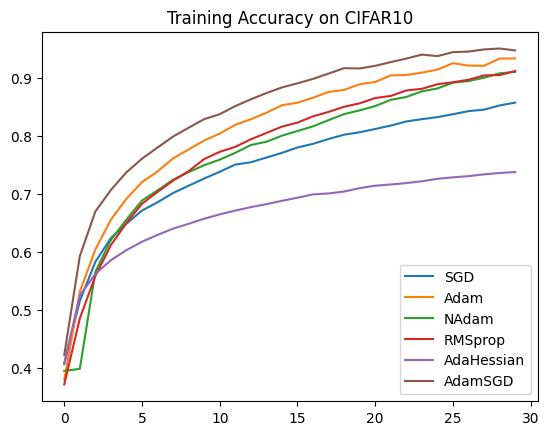

In [19]:
epoch_lst = range(30)
plt.plot(epoch_lst, accuracy_lst_SGD, label = "SGD")
plt.plot(epoch_lst, accuracy_lst_Adam, label = "Adam")
plt.plot(epoch_lst, accuracy_lst_NAdam, label = "NAdam")
plt.plot(epoch_lst, accuracy_lst_RMSprop, label = "RMSprop")
plt.plot(epoch_lst, accuracy_lst_Adahess, label = "AdaHessian")
plt.plot(epoch_lst, accuracy_lst_AdamSGD, label = "AdamSGD")
plt.legend()
plt.title('Training Accuracy on CIFAR10')
plt.savefig('Training Accuracy on CIFAR10.png')
plt.show()

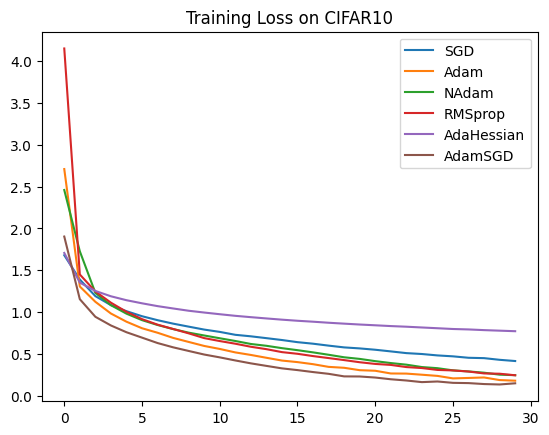

In [20]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_SGD, label = "SGD")
plt.plot(epoch_lst, loss_lst_Adam, label = "Adam")
plt.plot(epoch_lst, loss_lst_NAdam, label = "NAdam")
plt.plot(epoch_lst, loss_lst_RMSprop, label = "RMSprop")
plt.plot(epoch_lst, loss_lst_Adahess, label = "AdaHessian")
plt.plot(epoch_lst, loss_lst_AdamSGD, label = "AdamSGD")
plt.legend()
plt.title('Training Loss on CIFAR10')
plt.savefig('Training Loss on CIFAR10.png')
plt.show()

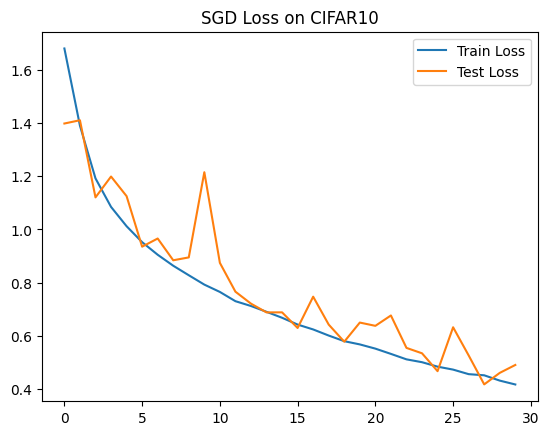

In [21]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_SGD, label = "Train Loss")
plt.plot(epoch_lst, testloss_SGD, label = "Test Loss")
plt.legend()
plt.title('SGD Loss on CIFAR10')
plt.savefig('SGD Loss on CIFAR10.png')
plt.show()

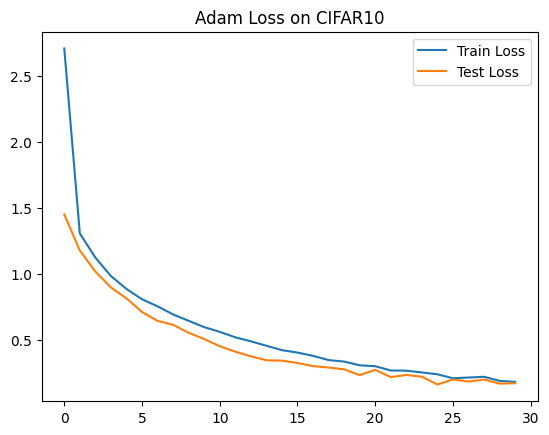

In [22]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_Adam, label = "Train Loss")
plt.plot(epoch_lst, testloss_Adam, label = "Test Loss")
plt.legend()
plt.title('Adam Loss on CIFAR10')
plt.savefig('Adam Loss on CIFAR10.png')
plt.show()

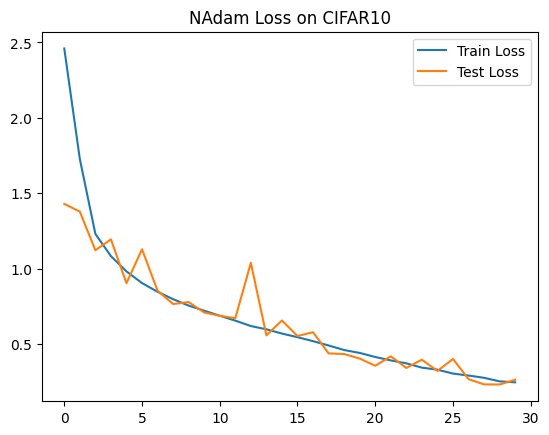

In [23]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_NAdam, label = "Train Loss")
plt.plot(epoch_lst, testloss_NAdam, label = "Test Loss")
plt.legend()
plt.title('NAdam Loss on CIFAR10')
plt.savefig('NAdam Loss on CIFAR10.png')
plt.show()

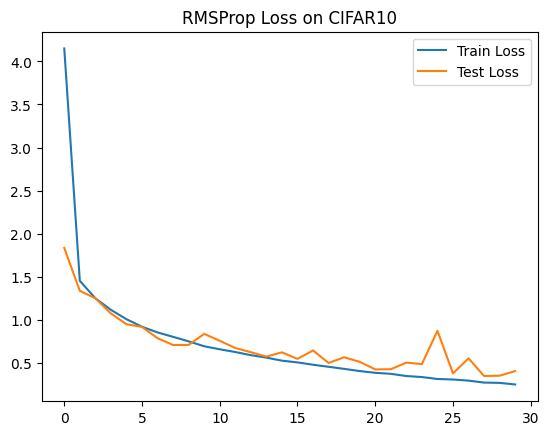

In [24]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_RMSprop, label = "Train Loss")
plt.plot(epoch_lst, testloss_RMSProp, label = "Test Loss")
plt.legend()
plt.title('RMSProp Loss on CIFAR10')
plt.savefig('RMSProp Loss on CIFAR10.png')
plt.show()

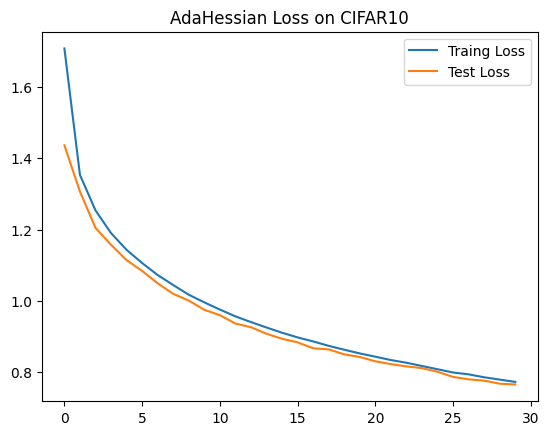

In [25]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_Adahess, label = "Traing Loss")
plt.plot(epoch_lst, testloss_Adahess, label = "Test Loss")
plt.legend()
plt.title('AdaHessian Loss on CIFAR10')
plt.savefig('AdaHessian Loss on CIFAR10.png')
plt.show()

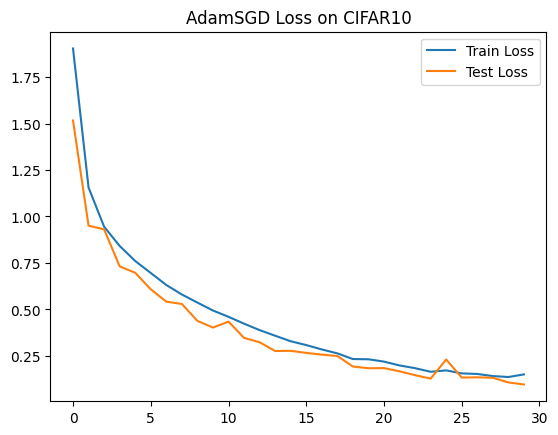

In [12]:
epoch_lst = range(30)
plt.plot(epoch_lst, loss_lst_AdamSGD, label = "Train Loss")
plt.plot(epoch_lst, testloss_AdamSGD, label = "Test Loss")
plt.legend()
plt.title('AdamSGD Loss on CIFAR10')
plt.savefig('AdamSGD Loss on CIFAR10.png')
plt.show()

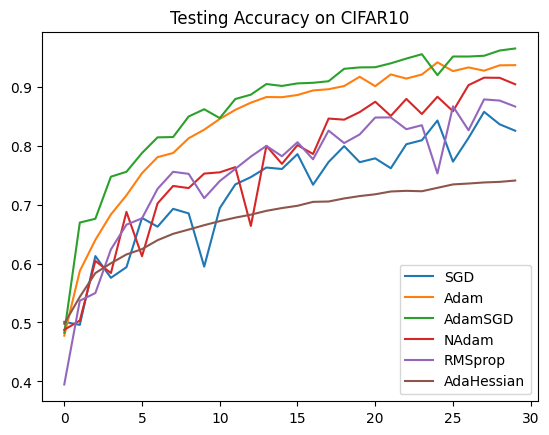

In [29]:
epoch_lst = range(30)
plt.plot(epoch_lst, testacc_SGD, label = "SGD")
plt.plot(epoch_lst, testacc_Adam, label = "Adam")
plt.plot(epoch_lst, testacc_AdamSGD, label = "AdamSGD")
plt.plot(epoch_lst, testacc_NAdam, label = "NAdam")
plt.plot(epoch_lst, testacc_RMSProp, label = "RMSprop")
plt.plot(epoch_lst, testacc_Adahess, label = "AdaHessian")
plt.legend()
plt.title('Testing Accuracy on CIFAR10')
plt.savefig('Testing Accuracy on CIFAR10.png')
plt.show()

Comparing individual optimizers and the combination

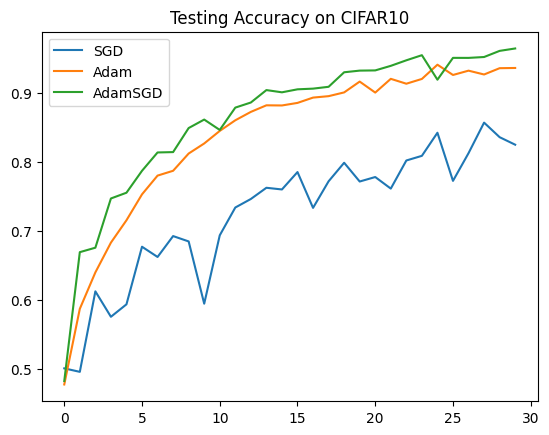

In [30]:
epoch_lst = range(30)
plt.plot(epoch_lst, testacc_SGD, label = "SGD")
plt.plot(epoch_lst, testacc_Adam, label = "Adam")
plt.plot(epoch_lst, testacc_AdamSGD, label = "AdamSGD")
plt.legend()
plt.title('Testing Accuracy on CIFAR10')
plt.savefig('Testing Accuracy on CIFAR10.png')
plt.show()